In [1]:
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import multivariate_normal as smn
#from jax.scipy.stats import multivariate_normal as jmn
#from jax import random
import scipy

import jax.numpy as jnp
#numpyro.set_platform("cpu")

In [101]:
def RBF(t,tau):
    Dt = t - np.array([t]).T
    K=np.exp(-(Dt)**2/2/(tau**2)+0.001*jnp.eye(N))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32(t,tau):
    Dt = t - np.array([t]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [102]:
np.random.seed(seed=1)
N = 101
t = np.linspace(0,4*np.pi,N)
ave = np.zeros(N)
tau = 0.5

ave = jnp.zeros(N)
cov = RBF(t,tau)
#cov = Matern32(t,tau)
alpha=1.5
m=smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
di = np.abs(m)**alpha
#key = random.PRNGKey(4)
#d=jmn(ave,cov,allow_singular =True).rvs(1).T


sigma=0.3
d=di+np.random.normal(0.0,sigma,len(m))

Text(0.5, 0, 't')

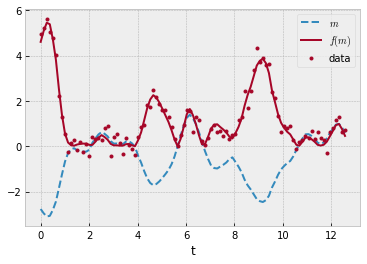

In [103]:
import seaborn as sns
plt.style.use('bmh')
plt.plot(t,m,ls="dashed",label="$m$")
plt.plot(t,di,color="C1",label="$f(m)$")
plt.plot(t,d,".",color="C1",label="data")
plt.legend()
plt.xlabel("t")

In [51]:
def muGP(tau,sigma):
    cov = RBF(t,tau)
    Pid=np.eye(N)/sigma**2
    IKw=np.eye(N)+Pid@cov
    A=scipy.linalg.solve(IKw,Pid@d,assume_a="pos")
    return cov@A

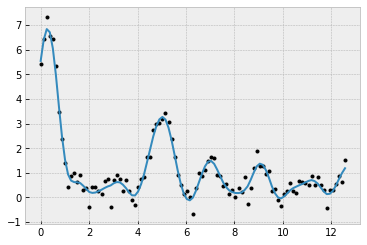

In [52]:



#cov@Pid@d
plt.plot(t,d,".",color="black")
plt.plot(t,muGP(tau,sigma))
#plt.plot(t,muGP(3.,sigma))

In [104]:
from jax import jit
@jit
def jRBF(t,tau,sigma):
    Dt = t - jnp.array([t]).T
    K=jnp.exp(-(Dt)**2/2/(tau**2)+0.001*jnp.eye(N))
    return K

In [125]:
2*(t[2]-t[1])

0.25132741228718347

In [126]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(t,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    #tau=0.5
    tau = numpyro.sample('tau', dist.Uniform(0.25,1.0))
    alpha = numpyro.sample('alpha', dist.Exponential(1.))
    cov = jRBF(t,tau,sigma)
    m=numpyro.sample('m', dist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=cov))
    numpyro.sample('y', dist.Normal(jnp.power(jnp.abs(m),alpha), sigma),
                   obs=y)

In [127]:
from numpyro.infer import MCMC, NUTS
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, t=t, y=d)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [04:38<00:00, 12.01it/s, 127 steps of size 5.07e-02. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.57      0.20      1.55      1.27      1.88    285.96      1.00
      m[0]     -2.79      0.36     -2.76     -3.40     -2.23    270.10      1.00
      m[1]     -2.98      0.40     -2.94     -3.58     -2.31    260.08      1.00
      m[2]     -3.05      0.42     -3.02     -3.69     -2.39    255.05      1.00
      m[3]     -2.95      0.39     -2.92     -3.57     -2.33    252.10      1.00
      m[4]     -2.71      0.33     -2.68     -3.19     -2.14    253.92      1.00
      m[5]     -2.31      0.24     -2.29     -2.71     -1.94    258.56      1.00
      m[6]     -1.78      0.16     -1.77     -2.03     -1.54    308.36      1.00
      m[7]     -1.23      0.11     -1.23     -1.41     -1.05   1020.76      1.00
      m[8]     -0.71      0.13     -0.72     -0.92     -0.51   1340.60      1.00
      m[9]     -0.28      0.16     -0.28     -0.52      0.00   1063.11      1.00
     m[10]      0.01      0

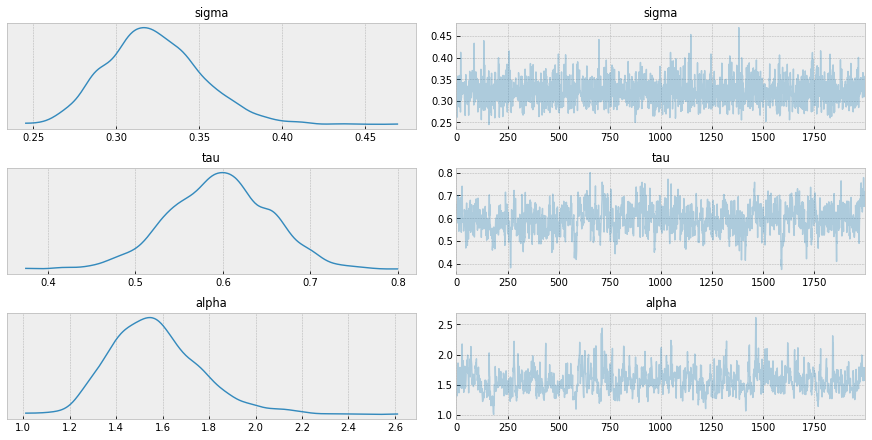

In [129]:
import arviz
arviz.plot_trace(mcmc, var_names=["sigma","tau","alpha"])
#arviz.plot_trace(mcmc, var_names=["sigma","alpha"])
plt.savefig("gps2.pdf")

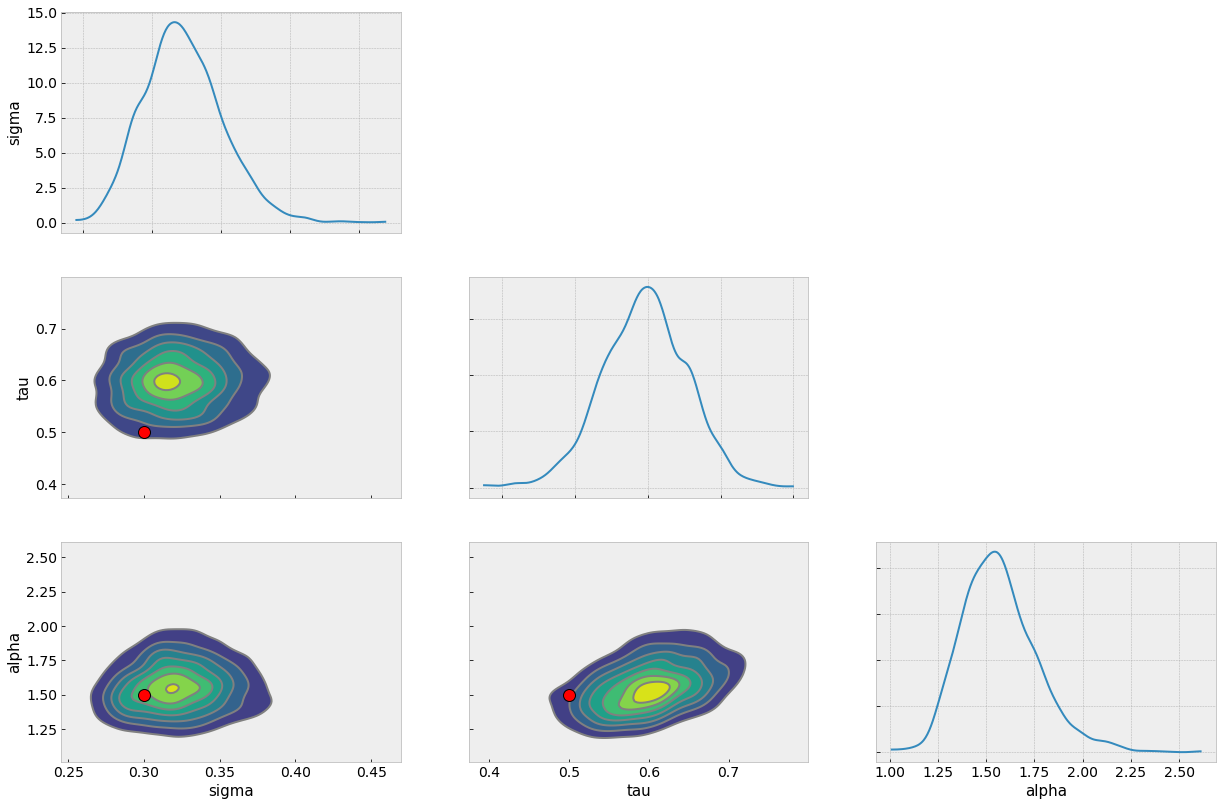

In [130]:
refs={};refs["sigma"]=sigma;refs["tau"]=tau;refs["alpha"]=alpha
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',var_names=["sigma","tau","alpha"],
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("gp2s.pdf", bbox_inches="tight", pad_inches=0.0)

In [131]:
posterior_m = mcmc.get_samples()['m']

In [142]:
posterior_tau = mcmc.get_samples()['tau']
posterior_sigma = mcmc.get_samples()['sigma']
posterior_alpha = mcmc.get_samples()['alpha']

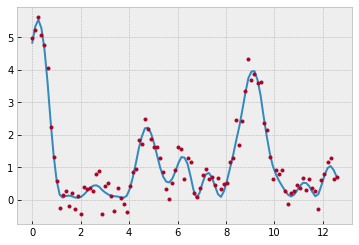

In [143]:
plt.plot(t,np.mean(jnp.abs(posterior_m)**(posterior_alpha[:,None]),axis=0))
plt.plot(t,d,".")

In [144]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(jnp.abs(posterior_m)**(posterior_alpha[:,None]), axis=0)
hpdi_muy = hpdi(jnp.abs(posterior_m)**(posterior_alpha[:,None]), 0.9)

In [148]:
import tqdm
Ns=len(posterior_sigma)
darr=[]
for i in tqdm.tqdm(range(0,Ns)):
    ms=(posterior_m[i,:])
    sigmas=float(posterior_sigma[i])
    alphas=float(posterior_alpha[i])
    ave=np.abs(ms)**alphas
    ds = ave + np.random.normal(0.0,sigmas,len(d))
    darr.append(ds)

mean_muy = np.mean(darr, axis=0)
hpdi_muy = hpdi(darr, 0.9)

100%|██████████| 2000/2000 [00:06<00:00, 330.51it/s]


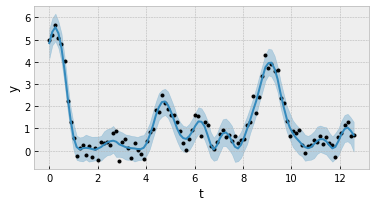

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t,d,".",color="black")
ax.plot(t,mean_muy,color="C0")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("gp3s.pdf")

In [213]:
from numpyro.infer import Predictive
pred = Predictive(model,{'tau':posterior_tau,'sigma':posterior_sigma},return_sites=["y"])
t_ = np.linspace(0,10,N)
predictions = pred(rng_key_,t=t_,y=None)

In [214]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

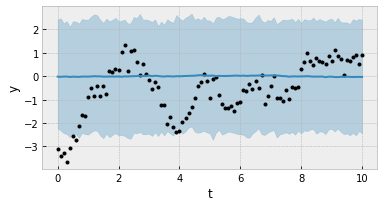

In [219]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t,d,".",color="black")
ax.plot(t_,mean_muy,color="C0")
ax.fill_between(t_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("gp3.pdf")

In [221]:
def muGP(tau,sigma):
    cov = RBF(t,tau)
    Pid=np.eye(N)/sigma**2
    IKw=np.eye(N)+Pid@cov
    A=scipy.linalg.solve(IKw,Pid@d,assume_a="pos")
    return cov@A

In [222]:
def covGP(tau,sigma):
    cov = RBF(t,tau)
    Pid=np.eye(N)/sigma**2
    IKw=np.eye(N)+Pid@cov
    IKw=scipy.linalg.inv(IKw)
    return cov@IKw

In [223]:
import tqdm
Ns=len(posterior_sigma)
darr=[]
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    #cov=covGP(taus,sigmas)
    #print(taus,sigmas)
    ave=muGP(taus,sigmas)
    ds = ave + np.random.normal(0.0,sigmas,len(d))
    darr.append(ds)

100%|██████████| 2000/2000 [00:13<00:00, 143.92it/s]


In [224]:
float(posterior_sigma[0])

0.3295789659023285

In [225]:
darr=np.array(darr)
np.shape(darr)

(2000, 101)

In [226]:
mean_muy = np.mean(darr, axis=0)
hpdi_muy = hpdi(darr, 0.9)

In [227]:
tau,sigma

(0.5, 0.3)

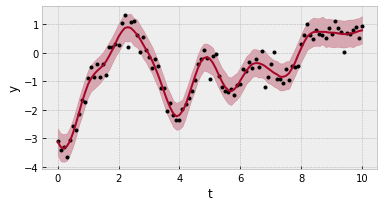

In [230]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t,d,".",color="black")
ax.plot(t_,mean_muy,color="C1")
#plt.plot(t,muGP(tau,sigma),color="C1",alpha=0.4)
#for i in range(0,10):
#    plt.plot(t,darr[i,:])
ax.fill_between(t_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("gp4.pdf")